In [1]:
# ! pip3 install fastprogress==0.1.22
# ! pip3 install "tensorflow_gpu>=1.14,<=2"
# ! pip3 install ktrain

In [2]:
import os
import shutil
from pathlib import Path

datasets_full = "dataset_preprocess"

users = os.listdir(datasets_full)

Path(os.path.join("jiradata", "test")).mkdir(parents=True, exist_ok=True)
Path(os.path.join("jiradata", "train")).mkdir(parents=True, exist_ok=True)

for user in users:
    # get list of files
    tickets = os.listdir(os.path.join(datasets_full, user))

    test = tickets[:len(tickets) // 2]
    train = tickets[len(tickets) // 2:]

    # copy test
    for ticket in test:
        Path(os.path.join("jiradata", "test", user)).mkdir(parents=True, exist_ok=True)
        shutil.copyfile(os.path.join(datasets_full, user, ticket), os.path.join("jiradata", "test", user, ticket))

    # copy test
    for ticket in test:
        Path(os.path.join("jiradata", "train", user)).mkdir(parents=True, exist_ok=True)
        shutil.copyfile(os.path.join(datasets_full, user, ticket), os.path.join("jiradata", "train", user, ticket))
# users = os.listdir("jiradata/train")
print("Done")

Done


In [3]:
%%time
import ktrain
from ktrain import text as txt

using Keras version: 2.2.4-tf
CPU times: user 2.5 s, sys: 208 ms, total: 2.71 s
Wall time: 2.71 s


In [4]:
%%time
# load data
(x_train, y_train), (x_test, y_test), preproc = txt.texts_from_folder('jiradata', maxlen=500, 
                                                                     preprocess_mode='bert',
                                                                     train_test_names=['train', 'test'],
                                                                     classes=users)

detected encoding: utf-8
preprocessing train...
language: en


preprocessing test...
language: en


CPU times: user 2min 30s, sys: 1.12 s, total: 2min 31s
Wall time: 2min 30s


In [5]:
%%time
# load model
model = txt.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.
CPU times: user 26.7 s, sys: 1.18 s, total: 27.9 s
Wall time: 28 s


In [6]:
%%time
# wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=10)

CPU times: user 1.15 s, sys: 444 ms, total: 1.6 s
Wall time: 1.56 s


simulating training for different learning rates... this may take a few moments...
Train on 8961 samples
Epoch 1/1024
8961/8961 [==============================] - 385s 43ms/sample - loss: 3.2744 - acc: 0.1265
Epoch 2/1024
3980/8961 [============>.................] - ETA: 3:30 - loss: 4.7496 - acc: 0.0930

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.
CPU times: user 4min 5s, sys: 4min 10s, total: 8min 15s
Wall time: 9min 33s


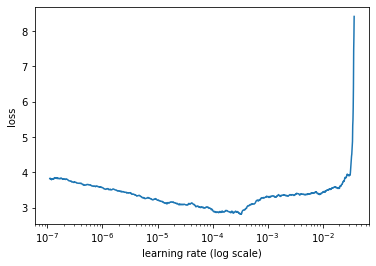

In [7]:
%%time
# find good learning rate
learner.lr_find()  # briefly simulate training to find good learning rate
learner.lr_plot()  # visually identify best learning rate

In [8]:
%%time
# employs the 1cycle learning rate policy
# 0.00002
# learner.fit_onecycle(2e-5, 10)

# # employs a triangular learning rate policy with automatic stopping
learner.autofit(0.000029, 10)



begin training using triangular learning rate policy with max lr of 2.9e-05...
Train on 8961 samples, validate on 8961 samples
Epoch 1/10
8961/8961 [==============================] - 498s 56ms/sample - loss: 2.7566 - acc: 0.2376 - val_loss: 2.1874 - val_acc: 0.3692
Epoch 2/10
8961/8961 [==============================] - 494s 55ms/sample - loss: 2.1426 - acc: 0.3670 - val_loss: 1.7298 - val_acc: 0.4801
Epoch 3/10
8961/8961 [==============================] - 494s 55ms/sample - loss: 1.7837 - acc: 0.4666 - val_loss: 1.3118 - val_acc: 0.6151
Epoch 4/10
8961/8961 [==============================] - 495s 55ms/sample - loss: 1.4362 - acc: 0.5710 - val_loss: 0.9192 - val_acc: 0.7459
Epoch 5/10
8961/8961 [==============================] - 494s 55ms/sample - loss: 1.0911 - acc: 0.6766 - val_loss: 0.5800 - val_acc: 0.8597
Epoch 6/10
8961/8961 [==============================] - 494s 55ms/sample - loss: 0.7656 - acc: 0.7807 - val_loss: 0.3283 - val_acc: 0.9279
Epoch 7/10
8961/8961 [===============

In [9]:
%%time
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('predictor')

CPU times: user 17.7 s, sys: 788 ms, total: 18.5 s
Wall time: 18.5 s
